In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sqlite3
import joblib


In [12]:
betting_columns = [
    'B365H', 'B365D', 'B365A',
    'BWH',  'BWD',  'BWA',
    'IWH',  'IWD',  'IWA',
    'LBH',  'LBD',  'LBA',
    'WHH',  'WHD',  'WHA',
    'VCH',  'VCD',  'VCA'
]
match_columns = ['match_api_id', 'season', 'stage', 'date', 
                 'home_team_api_id', 'away_team_api_id', 
                 'home_team_goal', 'away_team_goal', 
                 'league_id'] + betting_columns
team_columns = ['team_api_id', 'team_long_name', 'team_short_name']
league_columns = ['id', 'name']

In [14]:
conn = sqlite3.connect('database.sqlite')
match_df = pd.read_sql("SELECT * FROM Match", conn)[match_columns]
team_df = pd.read_sql("SELECT * FROM Team", conn)[team_columns]
league_df = pd.read_sql("SELECT * FROM League", conn)[league_columns]
conn.close()

In [15]:
match_df.dropna(subset=betting_columns, inplace=True)
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22432 entries, 0 to 24556
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   match_api_id      22432 non-null  int64  
 1   season            22432 non-null  object 
 2   stage             22432 non-null  int64  
 3   date              22432 non-null  object 
 4   home_team_api_id  22432 non-null  int64  
 5   away_team_api_id  22432 non-null  int64  
 6   home_team_goal    22432 non-null  int64  
 7   away_team_goal    22432 non-null  int64  
 8   league_id         22432 non-null  int64  
 9   B365H             22432 non-null  float64
 10  B365D             22432 non-null  float64
 11  B365A             22432 non-null  float64
 12  BWH               22432 non-null  float64
 13  BWD               22432 non-null  float64
 14  BWA               22432 non-null  float64
 15  IWH               22432 non-null  float64
 16  IWD               22432 non-null  float64
 17

In [29]:
teams = list(team_df['team_long_name'].unique())
print(teams)

['KRC Genk', 'Beerschot AC', 'SV Zulte-Waregem', 'Sporting Lokeren', 'KSV Cercle Brugge', 'RSC Anderlecht', 'KAA Gent', 'RAEC Mons', 'FCV Dender EH', 'Standard de Liège', 'KV Mechelen', 'Club Brugge KV', 'KSV Roeselare', 'KV Kortrijk', 'Tubize', 'Royal Excel Mouscron', 'KVC Westerlo', 'Sporting Charleroi', 'Sint-Truidense VV', 'Lierse SK', 'KAS Eupen', 'Oud-Heverlee Leuven', 'Waasland-Beveren', 'KV Oostende', 'Manchester United', 'Newcastle United', 'Arsenal', 'West Bromwich Albion', 'Sunderland', 'Liverpool', 'West Ham United', 'Wigan Athletic', 'Aston Villa', 'Manchester City', 'Everton', 'Blackburn Rovers', 'Middlesbrough', 'Tottenham Hotspur', 'Bolton Wanderers', 'Stoke City', 'Hull City', 'Fulham', 'Chelsea', 'Portsmouth', 'Birmingham City', 'Wolverhampton Wanderers', 'Burnley', 'Blackpool', 'Swansea City', 'Queens Park Rangers', 'Norwich City', 'Southampton', 'Reading', 'Crystal Palace', 'Cardiff City', 'Leicester City', 'Bournemouth', 'Watford', 'AJ Auxerre', 'FC Nantes', 'Giron

In [28]:
leagues = league_df['name'].unique()
print(leagues)

['Belgium Jupiler League' 'England Premier League' 'France Ligue 1'
 'Germany 1. Bundesliga' 'Italy Serie A' 'Netherlands Eredivisie'
 'Poland Ekstraklasa' 'Portugal Liga ZON Sagres' 'Scotland Premier League'
 'Spain LIGA BBVA' 'Switzerland Super League']


In [16]:
# Merge team names (for home and away teams) into match_df
match_df = match_df.merge(team_df, left_on='home_team_api_id', right_on='team_api_id', how='left') \
                   .rename(columns={'team_long_name': 'home_team_long_name',
                                    'team_short_name': 'home_team_short_name'}) \
                   .drop('team_api_id', axis=1)

match_df = match_df.merge(team_df, left_on='away_team_api_id', right_on='team_api_id', how='left') \
                   .rename(columns={'team_long_name': 'away_team_long_name',
                                    'team_short_name': 'away_team_short_name'}) \
                   .drop('team_api_id', axis=1)

# Merge league names
match_df = match_df.merge(league_df, left_on='league_id', right_on='id', how='left') \
                   .rename(columns={'name': 'league_name'}) \
                   .drop('id', axis=1)

# Convert date column to datetime and create additional features
match_df['date'] = pd.to_datetime(match_df['date'])
match_df['year'] = match_df['date'].dt.year
match_df['goal_diff'] = match_df['home_team_goal'] - match_df['away_team_goal']

In [20]:
match_df['match_result'] = match_df.apply(
    lambda row: 'Home Win' if row['home_team_goal'] > row['away_team_goal']
                else ('Away Win' if row['home_team_goal'] < row['away_team_goal']
                      else 'Draw'),
    axis=1
)

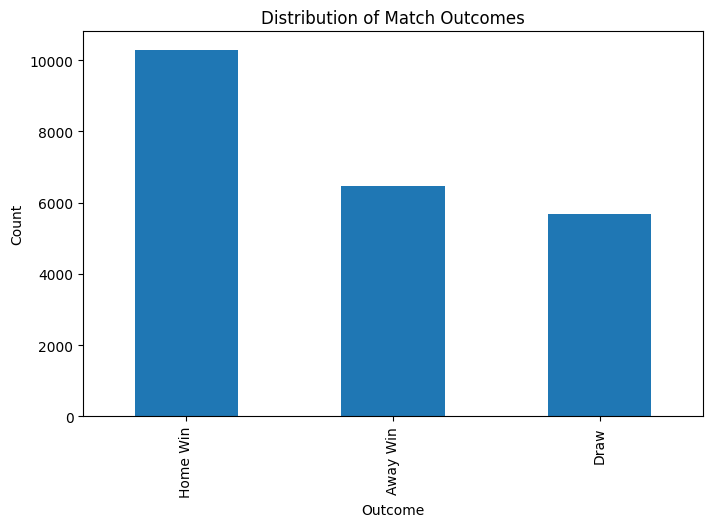

In [21]:
plt.figure(figsize=(8, 5))
match_df['match_result'].value_counts().plot(kind='bar')
plt.title('Distribution of Match Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

In [25]:
# Filtering categorical and numeric columns
cat_cols = ['home_team_long_name', 'away_team_long_name', 'league_name']
num_cols = ['stage', 'year'] + betting_columns

# Drop rows with missing odds or target
match_df.dropna(subset=betting_columns + ['match_result'], inplace=True)

# Encode the target (Draw / Home Win / Away Win) as integers
le = LabelEncoder()
match_df['result_encoded'] = le.fit_transform(match_df['match_result'])

# Build preprocessing and model pipeline
preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', 'passthrough',     num_cols)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])


In [26]:
# Train / test split
X = match_df[cat_cols + num_cols]
y = match_df['result_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train & evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.513372956909361

Classification Report:
               precision    recall  f1-score   support

    Away Win       0.48      0.47      0.47      1938
        Draw       0.29      0.10      0.15      1703
    Home Win       0.56      0.77      0.65      3089

    accuracy                           0.51      6730
   macro avg       0.44      0.45      0.42      6730
weighted avg       0.47      0.51      0.47      6730


Confusion Matrix:
 [[ 905  174  859]
 [ 499  166 1038]
 [ 470  235 2384]]


In [27]:
# Saving the entire pipeline (preprocessing + model + label encoder)
joblib.dump({
    'pipeline': pipeline,
    'label_encoder': le
}, 'full_model.pkl')

['full_model.pkl']